In [62]:
from Annotation_helper import *
import numpy as np
from collections import defaultdict
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tempfile
import matplotlib as mpl
import matplotlib.pyplot as plt

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Helper functions

In [64]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

# Loading data

In [65]:
matches = pd.read_csv("Matches/Bas3.csv", index_col=0)
transactions = load_transactions("../../Data/structured_data\VOC Cochin Slave Transactions 1706-1801 - IISH - Database - 2018 - v1.csv")
permissions = load_permissions("../../Data/structured_data\VOC Cochin Slave Transport Permissions 1770-1795 - IISH - Database - 2018 - v1.csv")

In [66]:
distances = pd.read_csv("Distances/distances_0.csv", dtype={'permission_indx': 'uint16', 'transaction_indx': 'uint16', 'SlaafGender': 'bool', 'SlaafNaamNieuw': 'float16', 'BezitterGender': 'bool', 'BezitterVoornaam': 'float16', 'BezitterBeroep': 'float16', 'BezitterAchternaam': 'float16'})
for i in range(1, 99):
    df2 = pd.read_csv(f"Distances/distances_{i}.csv", dtype={'permission_indx': 'uint16', 'transaction_indx': 'uint16', 'SlaafGender': 'bool', 'SlaafNaamNieuw': 'float16', 'BezitterGender': 'bool', 'BezitterVoornaam': 'float16', 'BezitterBeroep': 'float16', 'BezitterAchternaam': 'float16'})
    distances = pd.concat([distances, df2])

In [67]:
matches

,Annotator,transaction_indx,permission_indx
0,Bas,None,0
1,Bas,None,1
2,Bas,None,2
3,Bas,None,3
4,Bas,None,4
...,...,...,...
63,Bas,4240,62
64,Bas,2485,63
65,Bas,4164,64
66,Bas,4241,65


In [68]:
X = distances[distances['permission_indx'].isin(matches["permission_indx"].unique())]
X["Match"] = 0
for i, match in matches.iterrows():
    if match["transaction_indx"] != "None":
        indx = distances.query(f"permission_indx == {match['permission_indx']} & transaction_indx == {match['transaction_indx']}").index[0]
        X.loc[indx, "Match"] = 1
data = X.to_numpy().astype("float")[:, 2:-1]
y = X.to_numpy().astype("float")[:, -1]
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, random_state=42)

<ipython-input-68-ffcdc5c95887>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Match"] = 0
C:\Users\basvd\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\basvd\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

C:\Users\basvd\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\basvd\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\basvd\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [69]:
X

,permission_indx,transaction_indx,SlaafGender,SlaafNaamNieuw,BezitterGender,BezitterVoornaam,BezitterBeroep,BezitterAchternaam,Match
0,0,0,True,0.000000,False,0.000000,0.0,0.000000,0
1,0,1,True,0.250000,False,0.000000,0.0,0.000000,0
2,0,2,False,0.166626,False,0.000000,0.0,0.000000,0
3,0,3,True,0.111084,False,0.000000,0.0,0.000000,0
4,0,4,True,0.142822,False,0.000000,0.0,0.000000,0
...,...,...,...,...,...,...,...,...,...
201259,66,7192,True,0.000000,True,0.222168,0.0,0.000000,0
201260,66,7193,False,0.000000,True,0.222168,0.0,0.000000,0
201261,66,7194,False,0.166626,True,0.111084,0.0,0.166626,0
201262,66,7195,False,0.111084,True,0.000000,0.0,0.166626,0


# Normalizing data

In [70]:
X

,permission_indx,transaction_indx,SlaafGender,SlaafNaamNieuw,BezitterGender,BezitterVoornaam,BezitterBeroep,BezitterAchternaam,Match
0,0,0,True,0.000000,False,0.000000,0.0,0.000000,0
1,0,1,True,0.250000,False,0.000000,0.0,0.000000,0
2,0,2,False,0.166626,False,0.000000,0.0,0.000000,0
3,0,3,True,0.111084,False,0.000000,0.0,0.000000,0
4,0,4,True,0.142822,False,0.000000,0.0,0.000000,0
...,...,...,...,...,...,...,...,...,...
201259,66,7192,True,0.000000,True,0.222168,0.0,0.000000,0
201260,66,7193,False,0.000000,True,0.222168,0.0,0.000000,0
201261,66,7194,False,0.166626,True,0.111084,0.0,0.166626,0
201262,66,7195,False,0.111084,True,0.000000,0.0,0.166626,0


In [71]:
X[X["Match"] == 1]

,permission_indx,transaction_indx,SlaafGender,SlaafNaamNieuw,BezitterGender,BezitterVoornaam,BezitterBeroep,BezitterAchternaam,Match
11387,1,4202,True,0.142822,False,0.000000,0.000000,0.000000,1
25778,3,4217,True,0.000000,False,0.000000,0.000000,0.000000,1
32931,4,4182,True,0.000000,False,0.000000,0.000000,0.000000,1
40156,5,4219,True,0.125000,False,0.000000,0.000000,0.000000,1
47308,6,4183,True,0.099976,False,0.000000,0.000000,0.000000,1
54530,7,4217,True,0.250000,False,0.000000,0.000000,0.000000,1
68872,9,4183,True,0.111084,False,0.000000,0.000000,0.000000,1
76074,10,4197,True,0.000000,False,0.000000,0.000000,0.000000,1
83321,11,4256,True,0.142822,False,0.000000,0.000000,0.000000,1
90451,12,4198,True,0.111084,False,0.000000,0.000000,0.000000,1


In [72]:
X.query(f"permission_indx == 40 & transaction_indx == 4202")

,permission_indx,transaction_indx,SlaafGender,SlaafNaamNieuw,BezitterGender,BezitterVoornaam,BezitterBeroep,BezitterAchternaam,Match
11387,40,4202,True,1.0,True,1.0,1.0,0.856934,1


In [73]:
matches[matches["transaction_indx"] != "None"]

,Annotator,transaction_indx,permission_indx
30,Bas,4097,32
31,Bas,4242,33
32,Bas,4242,33
33,Bas,4228,34
37,Bas,4220,38
39,Bas,4202,40
40,Bas,4202,40
42,Bas,4217,42
43,Bas,4182,43
44,Bas,4219,44


# Oversampling

In [91]:
ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(X_train, y_train)

# Rule based

In [92]:
pred = []
for x in X_test:
    if (x == 1.).sum() >= 4:
        pred.append(1)
    else:
        pred.append(0)

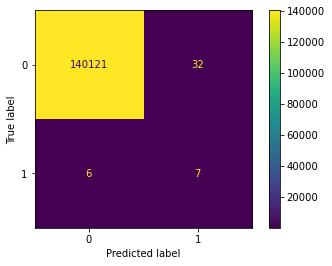

In [93]:
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [94]:
pred = []
for x in X_train:
    if x[1] == 1. and x[3] == 1.:
        pred.append(1)
    else:
        pred.append(0)

# All 0

In [95]:
pred = np.zeros(len(y_test))
pred

array([0., 0., 0., ..., 0., 0., 0.])

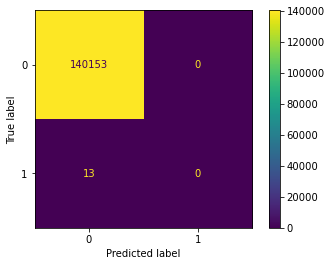

In [96]:


cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Logistic regression

In [97]:
from sklearn.linear_model import LogisticRegression

In [98]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
pred = clf.predict(X_test)

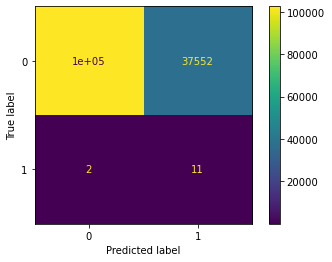

In [99]:
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [100]:
pred

array([0., 0., 0., ..., 0., 1., 1.])

In [101]:
recall_score(y_test, pred)

0.8461538461538461

In [102]:
precision_score(y_test, pred)

0.0002928413598487874

In [103]:
f1_score(y_test, pred)

0.0005854800936768151

# Naive Bayes

In [104]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

In [105]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
pred = clf.predict(X_test)

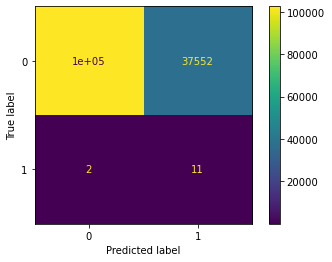

In [106]:
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

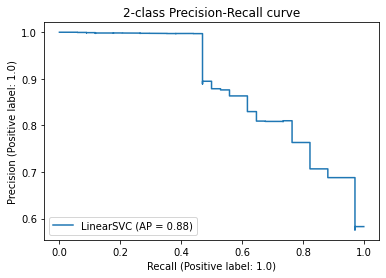

In [107]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    clf, X_train, y_train, name="LinearSVC"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

# Evaluating results

In [115]:
import tensorflow as tf
from tensorflow import keras

In [116]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(X_train.shape[-1]),
    tf.keras.layers.Dense(1, activation='softmax')
])

In [125]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [126]:
history = model.fit(X_train, y_train, batch_size=2048, epochs=5)

Epoch 1/5
320/320 [==============================] - 3s 7ms/step - loss: 0.4088 - accuracy: 0.5000
Epoch 2/5
320/320 [==============================] - 2s 5ms/step - loss: 0.4088 - accuracy: 0.5000
Epoch 3/5
320/320 [==============================] - 2s 5ms/step - loss: 0.4088 - accuracy: 0.5000
Epoch 4/5
320/320 [==============================] - 2s 6ms/step - loss: 0.4088 - accuracy: 0.5000
Epoch 5/5
320/320 [==============================] - 2s 6ms/step - loss: 0.4088 - accuracy: 0.5000


In [119]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6)                 42        
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________


In [120]:
pred = model.predict(X_test)
pred

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

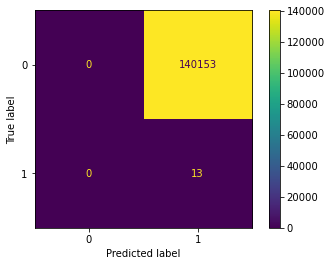

In [121]:
cm = confusion_matrix(y_test, np.round(pred.T[0]))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()